In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

#loading data
energy = pd.read_csv("household_power_consumption.txt", sep=";")

C:\Users\moren\AppData\Local\Temp\ipykernel_11232\2163305766.py:6: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  energy = pd.read_csv("household_power_consumption.txt", sep=";")


# EDA

In [2]:
# Many nan in sub3
energy.isna().value_counts()

Date   Time   Global_active_power  Global_reactive_power  Voltage  Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3
False  False  False                False                  False    False             False           False           False             2049280
                                                                                                                     True                25979
dtype: int64

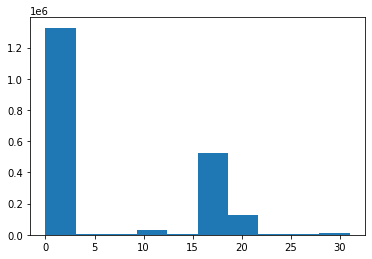

In [3]:
# Most values are 0
plt.hist(energy.Sub_metering_3)
plt.show();

In [4]:
# imputation of 0 suggested for heating
energy.Sub_metering_3.value_counts().head()

0.0     852092
1.0     471868
18.0    353163
17.0    156593
19.0    121326
Name: Sub_metering_3, dtype: int64

In [5]:
# 0 impute in kitchen
energy.Sub_metering_1.value_counts().head()

0.000    1840611
1.000      82920
0.0        39564
?          25979
2.000      18537
Name: Sub_metering_1, dtype: int64

In [6]:
energy.Global_active_power.value_counts().head()

?        25979
0.218     9491
0.216     9319
0.322     9226
0.324     9153
Name: Global_active_power, dtype: int64

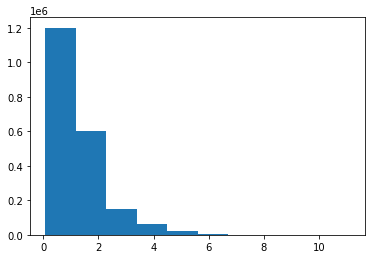

In [7]:
# median impute
plt.hist(energy.Global_active_power.loc[energy.Global_active_power != '?'].astype(float))
plt.show();

In [8]:
# 0 impute
energy.Sub_metering_2.value_counts().head()

0.000    1408274
1.000     367317
2.000     153938
0.0        28556
?          25979
Name: Sub_metering_2, dtype: int64

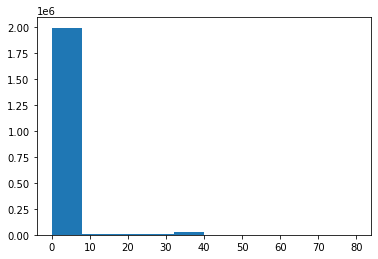

In [9]:
plt.hist(energy.Sub_metering_2.loc[energy.Sub_metering_2 != '?'].astype(float))
plt.show();

# Preprocessing

In [10]:
def processData(data):
    data = data.drop(['Voltage', 'Global_reactive_power', 'Global_intensity'], axis=1)
    data.columns = ["Day", 'Time', 'Total', 'Kitchen', 'Laundry', 'Heating']
    data.Heating = data.Heating.fillna(0)
    data.Kitchen.loc[data.Kitchen == '?'] = 0.0
    data.Kitchen = data.Kitchen.astype(float)
    data.Total.loc[data.Total == '?'] = data.Total.loc[data.Total != '?'].astype(float).median()
    data.Total = data.Total.astype(float)
    data.Laundry.loc[data.Laundry == '?'] = 0.0
    data.Laundry = data.Laundry.astype(float)
    data.Total = data.Total * (1000 / 60)
    data['Other'] = data.Total - data.Kitchen - data.Laundry - data.Heating
    data['Date'] = data.apply(lambda x: datetime.datetime.strptime(x[0] + ' ' + x[1], '%d/%m/%Y %H:%M:%S'), axis=1)
    data['Hour'] = data.Date.map(lambda x: x.hour)

    return data

In [11]:
processed = processData(energy)

C:\Users\moren\AppData\Local\Temp\ipykernel_11232\3003039889.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Kitchen.loc[data.Kitchen == '?'] = 0.0
C:\Users\moren\AppData\Local\Temp\ipykernel_11232\3003039889.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Total.loc[data.Total == '?'] = data.Total.loc[data.Total != '?'].astype(float).median()
C:\Users\moren\AppData\Local\Temp\ipykernel_11232\3003039889.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

In [12]:
byHour = processed.groupby(['Day', 'Hour']).agg(sum).reset_index()
byHour.Day = byHour.Day.apply(datetime.datetime.strptime, args=['%d/%m/%Y'])
byHour.sort_values(by=['Day', 'Hour'], inplace=True)
byHour.reset_index(drop=True, inplace=True)
byHour.iloc[:, [2, 3, 4, 5, 6]] = byHour.apply(lambda x: x[2:7] / 1000, axis=1)

In [13]:
byDay = byHour.groupby(['Day']).agg(sum).reset_index().drop(['Hour'], axis=1)
byDay['Weekday'] = byDay.Day.map(lambda x: x.dayofweek)

In [14]:
def weekday(day):
    dayName = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    return dayName[day]

In [15]:
byDay.Weekday = byDay.Weekday.map(weekday)

In [16]:
byHour = byHour.iloc[:,[0,1,3,4,5,6,2]]
byDay = byDay.iloc[:,[0,6,2,3,4,5,1]]

# Prices

In [17]:
prices = {'2006': [None,0.1191],
          '2007': [0.1211,0.1222],
          '2008': [0.1213,0.1203],
          '2009': [0.1206,0.1207],
          '2010': [0.1283,0.1350]}

In [18]:
def getPrice(day):
    global prices
    if day.month in [1,2,3,4,5,6]:
        return prices[str(day.year)][0]
    else:
        return prices[str(day.year)][1]

In [19]:
byDay['Price'] = byDay.Day.map(getPrice)
byHour['Price'] = byHour.Day.map(getPrice)

In [20]:
def datetime_hour(day, hour):
    hour = str(hour)
    if len(hour) == 1:
        hour = '0' + hour

    date = day.strftime("%d/%m/%Y, %H:%M:%S")[:12] + hour + day.strftime("%m/%d/%Y, %H:%M:%S")[14:]
    return datetime.datetime.strptime(date, '%d/%m/%Y, %H:%M:%S')

In [21]:
byHour['Datetime'] = byHour.apply(lambda x: datetime_hour(x[0], x[1]), axis=1)

In [22]:
from copy import deepcopy
byMonth = deepcopy(byDay)
byMonth['Month'] = byDay.Day.dt.to_period('M')
byMonth = byMonth.drop(['Day',"Weekday"],axis=1)
byMonth = byMonth.groupby(['Month','Price']).agg(sum).reset_index()

In [23]:
byDay.set_index('Day', inplace=True)
byHour.set_index(['Datetime'], inplace=True)
byMonth.set_index('Month',inplace=True)
byHour = byHour.drop(['Day','Hour'],axis=1)

In [24]:
costs = byMonth.apply(lambda x: round(x[0]*x[1:6],2),axis=1)
consumption = byMonth.drop('Price',axis=1)
costs.columns = ['Kitchen_Cost','Laundry_Cost','Heating_Cost','Other_Cost','Total_Cost']
consumption.columns = ['Kitchen_Consumption','Laundry_Consumption','Heating_Consumption','Other_Consumption','Total_Consumption']
byMonth = pd.concat([consumption,costs],axis=1)

In [25]:
costs = byHour.apply(lambda x: round(x[5]*x[0:5],2),axis=1)
consumption = byHour.drop('Price',axis=1)
costs.columns = ['Kitchen_Cost','Laundry_Cost','Heating_Cost','Other_Cost','Total_Cost']
consumption.columns = ['Kitchen_Consumption','Laundry_Consumption','Heating_Consumption','Other_Consumption','Total_Consumption']
byHour = pd.concat([consumption,costs],axis=1)

In [26]:
costs = byDay.apply(lambda x: x[6]*x[1:6],axis=1)
consumption = byDay.drop('Price',axis=1)
costs.columns = ['Kitchen_Cost','Laundry_Cost','Heating_Cost','Other_Cost','Total_Cost']
consumption.columns = ['Weekday','Kitchen_Consumption','Laundry_Consumption','Heating_Consumption','Other_Consumption','Total_Consumption']
byDay = pd.concat([consumption,costs],axis=1)

In [27]:
byMonth.index = [i.to_timestamp(how='end').date() for i in byMonth.index]

In [173]:
byHour['Hour'] = byHour.index.hour
byMonth['Month'] = byMonth.index.month
byMonth.index.names = ['Datetime']

In [201]:
def change_month(intMonth):
    nameMonth = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    return nameMonth[intMonth-1]

In [204]:
byMonth['Month'] = byMonth.Month.map(change_month)

In [205]:
byHour.to_csv('Energy by Hour.csv')
byDay.to_csv("Energy by Day.csv")
byMonth.to_csv("Energy by Month.csv")